In [1]:
import sys
import subprocess
import numpy as np
import pandas as pd
import scipy.io as sio

import os

from core import *
from math import floor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import normalized_mutual_info_score

import matplotlib.pyplot as plt



/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

In [2]:
data_folder='~/Bcells/GitHub/Bit/Data/'

In [36]:
table_summary= pd.DataFrame(columns=['Data','sen_ig','spec_ig' ,'ppv_ig' ,'sen_my' ,'spec_my' ,'ppv_my','size_full','size_ig'])
table_summary_my= pd.DataFrame(columns=['Data','sen_short','sen_mid','sen_long','spec_short','spec_mid','spec_long','ppv_short','ppv_mid','ppv_long'])
table_summary_clones= pd.DataFrame(columns=['Data','num_c_my','num_m_my' ,'num_ac_my' ,'num_acm_my' ,'num_c_ig','num_m_ig'])
table_a= pd.DataFrame(columns=['clone','table','ig'])

In [37]:
for i in range (1,30):

        table_a=table_a.append({'clone':data_folder+'clone_dataMS4_v'+str(i)+'.csv','table': data_folder+'sim_dataMS4_v'+str(i)+'.csv' ,'ig': data_folder+'sampleMS4_o'+str(i)+'_germ-pass.tab' }, ignore_index=True)


In [38]:
for i in range (1,29):
 
        table_a=table_a.append({'clone':data_folder+'clone_dataMS3_v'+str(i)+'.csv','table': data_folder+'sim_dataMS3_v'+str(i)+'.csv' ,'ig': data_folder+'sampleMS3_o'+str(i)+'_germ-pass.tab' }, ignore_index=True)

In [39]:
bins=np.arange(0,0.6,0.005)

In [40]:
table_short_neg=pd.read_csv('MS_negation_large.csv')

/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [41]:
def evaluate_ig_clones(clone_list_short):
    clone_vals_ig=np.unique(clone_list_short)
    count_clones=0 
    count_clone_members=0
    for i in range (0,clone_vals_ig.shape[0]):
        temp=np.where(clone_list_short==clone_vals_ig[i])
        if temp[0].shape[0]>1:
            count_clones=count_clones+1
            count_clone_members=count_clone_members+temp[0].shape[0]
    return count_clones,count_clone_members
def evaluate_clones(clusters_cosine_full_s):
    M_L=2000000

    total_clones_my=max(clusters_cosine_full_s[np.where(clusters_cosine_full_s<M_L)])
    total_aligned_clones_my=0
    aligned_clones=0
    for i in range (0,max(clusters_cosine_full_s[np.where(clusters_cosine_full_s<M_L)])):
        temp_in=np.where(clusters_cosine_full_s==i)
        #if temp_in[0].shape[0]>1:
        clone_flag=0
        j=0
        #for j in range(0, temp_in[0].shape[0]):
        while (clone_flag==0) & (j<temp_in[0].shape[0]):
            indice_in_ig=np.where(table_ig.SEQUENCE_ID==temp_in[0][j])
            if (indice_in_ig[0].shape[0]!=0) :
                clone_flag=1
            j=j+1
        aligned_clones=aligned_clones+clone_flag
        if clone_flag!=0 :
            total_aligned_clones_my=total_aligned_clones_my+temp_in[0].shape[0]
    return  total_clones_my,total_aligned_clones_my,aligned_clones


In [42]:
W_l=150             
M_L=2000000
for i in range(0,55):
    table_ig=pd.read_table(table_a.ig[i])
    table_clone=pd.read_csv(table_a.clone[i])
    table_full=pd.read_csv(table_a.table[i])

    clone_list_short=table_clone.values[table_ig.SEQUENCE_ID-1][:,1]
    rest_indices=np.setdiff1d(table_full.index, table_ig.SEQUENCE_ID-1)
    clone_list_rest=table_clone.values[rest_indices][:,1]
    clone_list=table_clone.SEED_SEQUENCE_ID[:]

    clone_table_for_ig=np.hstack((clone_list_short,clone_list_rest))
   # table_ig.CLONE

    ig_num_clones,ig_num_clone_members=evaluate_ig_clones(clone_list_short)
    table_clone_list=np.copy(clone_list_short)
    

    table_clone_list_full=np.copy(clone_list)
    fake_clones=np.arange(np.max(table_ig.CLONE.values),np.max(table_ig.CLONE.values)+table_clone_list_full.shape[0]-table_clone_list.shape[0],1)
    clusters_ig_full = np.hstack((table_ig.CLONE.values,fake_clones))

    labels_list_ig,cloned_list_full_ig=clone_inference(clone_table_for_ig ,clusters_ig_full)


    
 
    sensitivity_ig=sensitivity_comp(clone_table_for_ig ,clusters_ig_full)  
    print('sen=',sensitivity_ig)
    specificity_ig=specificity_comp(clone_table_for_ig ,clusters_ig_full,500) 
    print('specificity=',specificity_ig)
    ppv_ig=PPV_comp(clone_table_for_ig ,clusters_ig_full) 
    print('PPV=',ppv_ig)
    
    
    table_last=truncate_sequence_v(table_full.SEQUENCE,W_l)
    vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams,use_idf=True)
    tf_idf_matrix_full= vectorizer.fit_transform(table_last.end)
    matches_fast_s= awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 2000, 0)
    dist2nearestcosine=compute_dist2nearest(matches_fast_s)

    labels_list,cloned_list_full_f=clone_inference(clone_list,clone_list)

    
    MM=table_full.shape[0]
    df = pd.DataFrame(table_full.SEQUENCE[:MM].values)
    df2=pd.DataFrame(table_short_neg.values )
    table_r_f=df.append(df2,ignore_index=True)
    table_last_for_neg=truncate_sequence_rf(table_r_f[0],W_l,0)
    tf_idf_matrix_full_for_neg = vectorizer.fit_transform(table_last_for_neg.end)
    matches_fast_neg= awesome_cossim_top(tf_idf_matrix_full_for_neg[:MM,:], tf_idf_matrix_full_for_neg[MM:,:].transpose(), 5, 0)
    dist2nearestcosine_neg=compute_dist2nearest(matches_fast_neg)
    

    thresh_cosine_a=np.percentile(dist2nearestcosine_neg, 0.01)

    
    clusters_cosine_full_s=cluster_from_matches(matches_fast_s,thresh_cosine_a)
    my_num_clones,my_num_aligned_clone_members,my_num_aligned_clones=evaluate_clones(clusters_cosine_full_s)
    my_num_clone_members=np.sum(clusters_cosine_full_s<M_L)
    labels_list_short,cloned_list_full_short=clone_inference(clone_list,clusters_cosine_full_s)


    
    sensitivity_my=sensitivity_comp(clone_list ,clusters_cosine_full_s)  
    print('sen=',sensitivity_my)
    specificity_my=specificity_comp(clone_list ,clusters_cosine_full_s,500) 
    print('specificity=',specificity_my)
    ppv_my=PPV_comp(clone_list ,clusters_cosine_full_s) 
    print('PPV=',ppv_my)
    
    table_summary=table_summary.append({'Data': i,'sen_ig': sensitivity_ig ,'spec_ig': specificity_ig ,'ppv_ig': ppv_ig ,'sen_my': sensitivity_my ,'spec_my': specificity_my ,'ppv_my': ppv_my,'size_full':table_full.shape[0],'size_ig':clone_list_short.shape[0]}, ignore_index=True)
    table_summary_clones=table_summary_clones.append({'Data':i,'num_c_my':my_num_clones,'num_m_my':my_num_clone_members ,'num_ac_my':my_num_aligned_clones ,'num_acm_my':my_num_aligned_clone_members ,'num_c_ig':ig_num_clones,'num_m_ig':ig_num_clone_members},ignore_index=True)

/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9856321358160646
specificity= 0.9999999467617856
PPV= 0.999862820665184
sen= 0.7105969065159979
specificity= 0.9999904703596242
PPV= 0.9979316319752773


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9736127497395569
specificity= 0.9999993619674603
PPV= 0.9993557549787853
sen= 0.8055854522866146
specificity= 0.999985035236797
PPV= 0.990374416631311


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.8792451980707866
specificity= 0.9999983208899283
PPV= 0.9983487826105849
sen= 0.9333914873740073
specificity= 0.9999910047674733
PPV= 0.9923224384395021


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9934732736560978
specificity= 0.9999997894958426
PPV= 0.9999139485975128
sen= 0.44409883337968586
specificity= 0.9999981580886222
PPV= 0.9993696566799922


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9681272463449638
specificity= 0.999999671691609
PPV= 0.9999064070241528
sen= 0.4137699931545357
specificity= 0.9999945281934831
PPV= 0.9966213819684565


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9877663069666924
specificity= 0.9999995312316887
PPV= 0.9998738675175354
sen= 0.8705255318838252
specificity= 0.9999753310676198
PPV= 0.9908838973970298


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.909297520661157
specificity= 0.999999941112387
PPV= 0.9995071952796584
sen= 0.8448878680895451
specificity= 0.9999991166858051
PPV= 0.9989173446603036


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9720940357380606
specificity= 0.9999981348028826
PPV= 0.9996024684110997
sen= 0.7000517563279562
specificity= 0.9999951957043945
PPV= 0.9856604887007194


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9653422782984915
specificity= 0.9999997690864483
PPV= 0.9997873522944204
sen= 0.5567393082143759
specificity= 0.9999918602973012
PPV= 0.9957456190378158


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9865889262930367
specificity= 0.9999999482910181
PPV= 0.9999848395655084
sen= 0.5412980618371398
specificity= 0.9999988624023993
PPV= 0.9994641009323586


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9949900848468668
specificity= 1.0
PPV= 0.9999857041581839
sen= 0.8067980346951943
specificity= 0.9999772685513295
PPV= 0.9958353197836041


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9719648510548928
specificity= 1.0
PPV= 0.9992305360063211
sen= 0.8097562228959674
specificity= 0.9999864840832295
PPV= 0.9814966019555512


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9897345260218409
specificity= 0.9999956507556812
PPV= 0.9986239413342121
sen= 0.580307875081472
specificity= 0.9999967380667609
PPV= 0.9976813457518329


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.8688824847780918
specificity= 0.9999997135163009
PPV= 0.9994861270709352
sen= 0.7492087269105087
specificity= 0.9999914627857674
PPV= 0.991679793460592


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9602971292570609
specificity= 0.9999997368351798
PPV= 0.9999798716322496
sen= 0.7157334341758392
specificity= 0.9999614726703334
PPV= 0.9908269378787038


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9712488462058545
specificity= 0.9999997770283453
PPV= 0.9998857580802516
sen= 0.6137067804880917
specificity= 0.9999535104099891
PPV= 0.991951189236735


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9313777129077294
specificity= 1.0
PPV= 0.9999361271053571
sen= 0.8231802893768245
specificity= 0.999993187895848
PPV= 0.9919031087627269


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9834590934370434
specificity= 1.0
PPV= 0.9999442135909458
sen= 0.4529084555039388
specificity= 0.9999802306425041
PPV= 0.9942257517550336


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9693501468594667
specificity= 0.9999998186598966
PPV= 0.9996165337074152
sen= 0.8871653298689561
specificity= 0.9999976425786563
PPV= 0.9985139623960966


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9146666980972699
specificity= 0.9999998341395991
PPV= 0.9995895318602279
sen= 0.7705306664466525
specificity= 0.9999824740843124
PPV= 0.9792664671406159


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9187399314239866
specificity= 1.0
PPV= 0.9999522427161615
sen= 0.9465809153079966
specificity= 0.9999885719638424
PPV= 0.9885796397463887


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9865324010242269
specificity= 1.0
PPV= 0.9999313730995028
sen= 0.9345178008666535
specificity= 0.9999951874132346
PPV= 0.995002883581933


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9775061493240882
specificity= 1.0
PPV= 0.9998983757643719
sen= 0.8540982932628074
specificity= 0.9999694310784036
PPV= 0.972663077403246


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.988112020762469
specificity= 0.9999991976106629
PPV= 0.9995006846507409
sen= 0.8973193307380247
specificity= 0.9999843088307404
PPV= 0.9885091589530726


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9827958178901366
specificity= 0.9999998161088636
PPV= 0.9999530962348002
sen= 0.9670230126680311
specificity= 0.9999852887090842
PPV= 0.9922824942940599


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9937413953953548
specificity= 0.9999998206358459
PPV= 0.999809758896916
sen= 0.7601540194930921
specificity= 0.9999966817631496
PPV= 0.9980794996850462


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9375725777707942
specificity= 1.0
PPV= 0.9998855582712759
sen= 0.7465306388376826
specificity= 0.9999730145011044
PPV= 0.9820618307217618


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.962610085458934
specificity= 0.9999998124882805
PPV= 0.9999423990458571
sen= 0.719691434535847
specificity= 0.9999829364335271
PPV= 0.9801650763189225


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.748015555790749
specificity= 0.9999997206833946
PPV= 0.9998224159259805
sen= 0.7076443605754832
specificity= 0.9999948791955682
PPV= 0.9953975730354162


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9989533589884003
specificity= 0.9999996719160105
PPV= 0.9999354382881149
sen= 0.5596538563327347
specificity= 0.9999969816272966
PPV= 0.9994489780828525


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.8027686450262
specificity= 1.0
PPV= 0.9999452538342744
sen= 0.8701854072478333
specificity= 0.9999764418531358
PPV= 0.9939406064039106


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.971967308298162
specificity= 0.9999999252028872
PPV= 0.9999705345514528
sen= 0.9720303171532495
specificity= 0.9998876547365272
PPV= 0.9890333239021403


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9987647933942344
specificity= 0.9999999366727883
PPV= 0.9999934195800494
sen= 0.7093873347768928
specificity= 0.9999125451206383
PPV= 0.9974494359504569


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.8840280803987492
specificity= 0.9999994701184663
PPV= 0.9998848736164148
sen= 0.9010309081597924
specificity= 0.9999975019870557
PPV= 0.9990822808248891


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9952811629270173
specificity= 1.0
PPV= 0.9999962350146862
sen= 0.9466741968207404
specificity= 0.9999918832872686
PPV= 0.9969400030893115


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9862870575943581
specificity= 1.0
PPV= 0.9999458330574832
sen= 0.9746785472591925
specificity= 0.9999769582444377
PPV= 0.9872615103393122


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9499188704791061
specificity= 1.0
PPV= 0.9999813932025647
sen= 0.5961340634401038
specificity= 0.999999877511024
PPV= 0.9985315190488033


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9831794165083798
specificity= 1.0
PPV= 0.9997395825259875
sen= 0.6319075828300167
specificity= 0.9999872958257713
PPV= 0.9929812289796193


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.8803639591302237
specificity= 0.9999996177613557
PPV= 0.9999141510670119
sen= 0.6352806314356564
specificity= 0.9999978339810155
PPV= 0.9977761397283892


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9754428659992349
specificity= 0.999999874411303
PPV= 0.9999729568018714
sen= 0.9579953306161213
specificity= 0.9999841758241759
PPV= 0.9922538867182163


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9974314044816426
specificity= 1.0
PPV= 0.9998966715850992
sen= 0.871407367704962
specificity= 0.9999773545465103
PPV= 0.9851589101307685


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9759255314472746
specificity= 1.0
PPV= 0.999958429897218
sen= 0.7623254854623346
specificity= 0.9999930745398214
PPV= 0.993247231497062


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9750503142433444
specificity= 0.9999997535580063
PPV= 0.999705866381885
sen= 0.8105933549890545
specificity= 0.9999996303370094
PPV= 0.9982661158821611


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9720385235185016
specificity= 1.0
PPV= 0.9999335345542123
sen= 0.648336069810575
specificity= 0.9999543137625071
PPV= 0.9726482763339453


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9966958455393765
specificity= 0.9999989597217256
PPV= 0.9999194965705539
sen= 0.3456777349411618
specificity= 0.9999955788173336
PPV= 0.9992300781274762


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9940463232502215
specificity= 1.0
PPV= 0.999964350465481
sen= 0.9380837868624224
specificity= 0.9999982139439944
PPV= 0.9966061766509257


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9913655279902307
specificity= 0.9999953172291702
PPV= 0.9991801519856517
sen= 0.8583637283887139
specificity= 0.9999637941865114
PPV= 0.9902497121023595


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9803979089820475
specificity= 1.0
PPV= 0.9999754740859191
sen= 0.6811967086184758
specificity= 0.9999755566931149
PPV= 0.9849249725339675


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.8749793225531329
specificity= 1.0
PPV= 0.9999361671830578
sen= 0.7642491777358142
specificity= 0.9999965269461077
PPV= 0.9985824561403509


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9558699165732439
specificity= 0.9999998442913309
PPV= 0.9999636232150821
sen= 0.9438406351449466
specificity= 0.9999964965549457
PPV= 0.998936405905781


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.999537131588551
specificity= 0.9999995330687389
PPV= 0.9999762393109609
sen= 0.6388838551832892
specificity= 0.999961244705333
PPV= 0.9982246718626347


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9877078285845552
specificity= 0.9999988204069596
PPV= 0.9999015512332704
sen= 0.9106662342188526
specificity= 0.9999948392804483
PPV= 0.9979636392962891


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9785385022292753
specificity= 1.0
sen= 0.7957728057478681
specificity= 0.9999940803735201
PPV= 0.9953828591372127


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9966232748734578
specificity= 0.9999992707746362
PPV= 0.9999200295580672
sen= 0.3783731208148793
specificity= 0.9999894593788325
PPV= 0.9977667048387067


/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


sen= 0.9096614825920298
specificity= 0.9999987025624392
PPV= 0.9999467574678842
sen= 0.7609089158048757
specificity= 0.9999915666558546
PPV= 0.9972894687890304


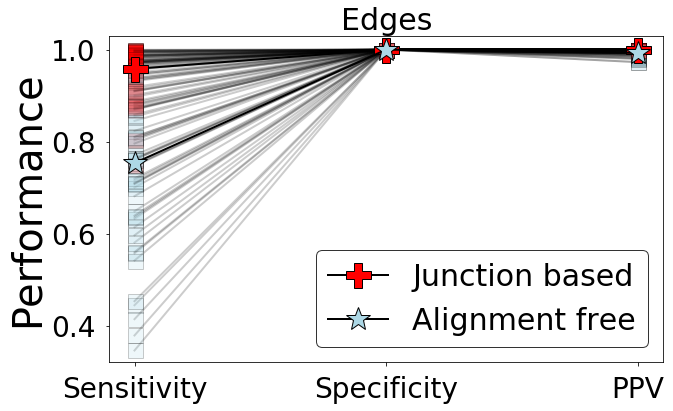

In [67]:
import matplotlib.pyplot as plt
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))
for i in range(0,55):
        plt.plot(['Sensitivity' ,'Specificity' ,'PPV'],[table_summary.sen_my[i],table_summary.spec_my[i],table_summary.ppv_my[i]],marker='s',markersize=15,linewidth=2,c='k',markerfacecolor='lightblue',markeredgecolor='k',alpha=0.2)
        plt.plot(['Sensitivity' ,'Specificity' ,'PPV'],[table_summary.sen_ig[i],table_summary.spec_ig[i],table_summary.ppv_ig[i]],marker='s',markersize=15,linewidth=2,c='k',markerfacecolor='r',markeredgecolor='k',alpha=0.2)
        ax.xaxis.label.set_fontsize(40)
        ax.yaxis.label.set_fontsize(40)
        ax.tick_params(labelsize=28,pad=10)
        plt.ylabel('Performance')
        ax.set_ylim([.32,1.03])

plt.plot(['Sensitivity' ,'Specificity' ,'PPV' ],[np.mean(table_summary.sen_ig[:]),np.mean(table_summary.spec_ig[:]),np.mean(table_summary.ppv_ig[:])],marker='P',markersize=25,linewidth=2,c='k',markerfacecolor='r',markeredgecolor='k',label='Junction based')
plt.plot(['Sensitivity' ,'Specificity' ,'PPV' ],[np.mean(table_summary.sen_my[:]),np.mean(table_summary.spec_my[:]),np.mean(table_summary.ppv_my[:])],marker='*',markersize=25,linewidth=2,c='k',markerfacecolor='lightblue',markeredgecolor='k',label='Alignment free')
l=plt.legend(fontsize=30,loc='lower right', bbox_to_anchor=(1, 0.0),edgecolor='k')
for text in l.get_texts():
    text.set_color("k")
plt.tight_layout()
#plt.show()
plt.title('Edges',fontsize=30)
plt.savefig('Figs/per-edges_fin')